**Deep Learning Assignment 1**:
Student name: Anthony Horgan  
id: 17452572  
All descriptions and code is taken from the lecture notes.

In [5]:
# Package imports
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import pandas as pd
import numpy as np
import cupy as cp
import pickle

# Display plots inline and change default figure size
%matplotlib inline

In [6]:
from google.colab import drive
import os
drive.mount('/content/drive')
circles_fname = "/content/drive/MyDrive/Colab Notebooks/dl_assignment1/circles600.csv"
blobs_fname = "/content/drive/MyDrive/Colab Notebooks/dl_assignment1/blobs300.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Part 1: Logistic Regression**  
This is an implementation of logistic regression to create a binary classification model. Logistic regression is a simple classification algorithm.  
Logistic regression consists of a learnable linear function followed by a non-linear activation function (sigmoid).  
For each attribute in the input data (independent variables), there is a trainable weight parameter (which is just a number). We multiply each input value with its corresponding weight, sum them all together and add a bias (bias is another trainable parameter). This result then gets fed through the sigmoid function to produce a value in the range [0, 1]. During the learning phase, a random input from the training set is chosen, the output is calculated, the log loss is used to calculate the difference between the output of logistic regression, the weights and bias parameters are then updated using stochastic gradient descent. (The weight and bias values are updated according to the derivative of the loss function with respect the weight and bias values multiplied by a learning rate)

In [8]:
epsilon = 1e-8
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def log_loss(y_hat, y):
    # add epsilon to avoid log(0)
    return - np.mean(y * np.log(y_hat + epsilon) + (1 - y) * np.log(1 - y_hat + epsilon))

In [9]:
# function to handle loading and sampling of data as well as storing and printing loss and accuracy 
def train(net, n_iter, train_set=None, val_set=None, evaluate_inter=1000, verbose=True):
    '''
    trains a classifier
            Parameters:
                    net: classifier to train. net must have forward(x) method and train_step(x, y) method
                    train_set : tuple of (input_data, input_labels). Used to train net
                    val_set: tuple of (input_data, input_labels). optional. Used to evaluate net.
                    evaluate_inter: (int), loss and accuracy scores will be caulated on train_set and val_set every evaluate_inter iterations
                    verbose: (bool) whether to print out loss and accuracy scores throughout training

            Returns:
                    train_loss_list, val_loss_list: lists of loss scores from every evaluation throughout training
    '''
    if verbose:
        print("starting training")
        print(f"iter\ttrain loss\ttrain acc\tval loss\tval acc")
    X_train, y_train = train_set
    X_val = y_val = None
    if val_set:
        X_val, y_val = val_set
    # lists which are used to store loss values from each evaluation step throughout training
    train_loss_list = []
    val_loss_list = []
    n_samples = X_train.shape[0]
    for iteration in range(n_iter):
        # get random sample
        sample_idx = np.random.choice(np.arange(n_samples))
        # forward step
        x_single, y_single = X_train[sample_idx], y_train[sample_idx]
        # backward step
        net.train_step(x_single, y_single)
        
        if iteration % evaluate_inter == 0:
            # every set amount of iterations, compute loss and accuracy on train and val set
            # get classifier output
            out = net(X_train)
            # get loss on entire set
            train_loss = log_loss(out, y_train)
            train_loss_list.append(train_loss)
            # get accuracy on entire set
            preds = out > 0.5
            train_acc = np.sum(np.squeeze(preds) == y_train)/X_train.shape[0]
            val_loss = None
            val_acc = None
            # if val set is given, compute loss and accuracy on val set
            if val_set:
                # get classifier output
                out = net(X_val)
                # get loss on entire set
                val_loss = log_loss(out, y_val)
                # get accuracy on entire set
                preds = out > 0.5
                val_acc = np.sum(np.squeeze(preds) == y_val)/X_val.shape[0]
                val_loss_list.append(val_loss)
                
                # print loss and accuracy
                if verbose:
                    print(f"{iteration:<6}\t{train_loss:.4f}\t\t{train_acc:.4f}\t\t{val_loss:.4f}\t\t{val_acc:.4f}")
            elif verbose:
                print(f"{iteration:<6}\t{train_loss:.4f}\t\t{train_acc:.4f}")
            
    return train_loss_list, val_loss_list

Each of the classifiers has a forward method to handle forward propagation and a train_step function to handle backward propagation (because backprop is handled in network object, optimization parameters need to be passed to init).  
Each of the classifiers can handle an arbitrary number of on the forward pass but not on the backward pass.

In [10]:
class LRClassifier:
    def __init__(self, n_attributes, lr=0.1):
        # init weights and biases
        self.w = np.random.randn(n_attributes)
        self.b = np.random.randn()
        self.lr = lr
    
    def forward(self, x):
        z = np.matmul(x, self.w) + self.b
        a = sigmoid(z)
        return a
    
    def __call__(self, x):
        return self.forward(x)

    def train_step(self, x_single, y_single):
        # handlesgradient descent

        # get classifier output
        y_hat= self.forward(x_single)
        
        # get loss
        loss = log_loss(y_hat, y_single)
        
        # calculate and store gradient for weights and bias
        w_gradients = (y_hat - y_single) * x_single
        b_gradient = y_hat - y_single
    
        # update weights and bias
        self.w -= self.lr * w_gradients
        self.b -= self.lr * b_gradient
        
        return loss

**Part 2**

In [11]:
def read_data(filename, val_size, test_size):
    # this function was extended from sample code given in LoadDataset.ipynb
    # Use pandas to read the CSV file as a dataframe
    df = pd.read_csv(filename)

    # The y values are those labelled 'Class': extract their values
    y = df['Class'].values

    # The x values are all other columns
    del df['Class']   # drop the 'Class' column from the dataframe
    X = df.values     # convert the remaining columns to a numpy array

    # val_size = test_size = 0.15

    n_train = int(X.shape[0] * (1 - val_size - test_size))
    n_val = int(X.shape[0] * val_size)
    n_test = int(X.shape[0] * test_size)

    perm = np.random.permutation(X.shape[0])
    X = X[perm]
    y = y[perm]
    X_train, X_val, X_test = X[:n_train], X[n_train:n_train+n_val], X[n_train+n_val:]
    y_train, y_val, y_test = y[:n_train], y[n_train:n_train+n_val], y[n_train+n_val:]
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [190]:
# train logistic regression on blobs and circles dataset
for filename in [blobs_fname, circles_fname]:
    print(filename)
    eval_inter = 1000
    train_set, val_set, test_set = read_data(filename, val_size=0.15, test_size=0.15)
    n_samples, n_attributes = train_set[0].shape
    net = LRClassifier(n_attributes, lr=0.1)
    # train logistic regression for 100 epochs
    train_loss_list, val_loss_list = train(net, 10_000, train_set=train_set, val_set=val_set, evaluate_inter=eval_inter)
    X_test, y_test = test_set
    out = net(X_test)
    preds = out > 0.5
    test_acc = np.sum(np.squeeze(preds) == y_test)/X_test.shape[0]
    print(f"test accuracy: {test_acc:.4f}")
    print()

/content/drive/MyDrive/Colab Notebooks/dl_assignment1/blobs300.csv
starting training
iter	train loss	train acc	val loss	val acc
0     	0.3043		0.8667		0.2724		0.8667
1000  	0.0393		0.9905		0.0085		1.0000
2000  	0.0247		0.9905		0.0065		1.0000
3000  	0.0207		0.9905		0.0035		1.0000
4000  	0.0181		0.9905		0.0038		1.0000
5000  	0.0189		1.0000		0.0062		1.0000
6000  	0.0146		0.9952		0.0021		1.0000
7000  	0.0138		1.0000		0.0024		1.0000
8000  	0.0126		0.9952		0.0014		1.0000
9000  	0.0118		1.0000		0.0014		1.0000
test accuracy: 1.0000

/content/drive/MyDrive/Colab Notebooks/dl_assignment1/circles600.csv
starting training
iter	train loss	train acc	val loss	val acc
0     	0.7955		0.5286		0.8527		0.4444
1000  	0.7032		0.6857		0.7444		0.6111
2000  	0.6999		0.3619		0.6877		0.4444
3000  	0.7003		0.6238		0.7300		0.5556
4000  	0.6994		0.5286		0.7327		0.4444
5000  	0.6958		0.6762		0.6990		0.6556
6000  	0.6928		0.6833		0.6988		0.6000
7000  	0.6941		0.6881		0.7101		0.6111
8000  	0.6986		0.5286		0.7338		0.44

Logistic regression can easily solve the blobs dataset. It gets almost 100% train and val accuracy after 1000 iterations. This is because the blobs dataset is linearly separable.  
Logistic regression struggles with the circles dataset. After 10,000 iterations it does no better than 50% which is as good as random guessing. It does get slightly better than 50% but not much. The circles dataset is not linearly separable.

**Part 3**

A shallow neural network can be seen as an extension of logistic regression.  
Whereas logistic regrssion consisted only of a single output node, a shallow neural network consists of a single layer of (multiple) hidden nodes and an output node. Each node has weights and a bias. For the first layer, each node multiplies its weight by the corresponding input attributes, sums this together, adds the bias and feeds it through a sigmoid activation function to produce the output for that node. The final node multiplies its weights by the corresponding outputs of the nodes in the previous layer, sums this together, adds the bias and sends this through a sigmoid activation function to produce the network output.  
The training process is the same as for logistic regression except the gradients for the weights/biases in the hidden layer need to be calculated differently to the weights/biases in the output layer.

In [12]:
def sigmoid_inverse(x):
    # inverse of sigmoid function, useful when we need to calculate z from activation during the backward pass
    return -np.log((1 / x) - 1)

In [13]:
class ShallowNN:
    def __init__(self, n_attributes, n_hidden_nodes, lr=0.1):
        self.lr = lr
        
        # initialize weights
        self.w_out = np.random.randn(1, n_hidden_nodes)
        self.b_out = np.random.randn(1, 1)
        self.w_hidden = np.random.randn(n_hidden_nodes, n_attributes)
        self.b_hidden = np.random.randn(n_hidden_nodes, 1)
        # a_hidden_cache stores the activations from the hidden layer because they are needed during backprop
        self.a_hidden_cache = None    
    
    def forward(self, x):
        # hidden layer
        x = x.transpose()
        z_hidden = np.matmul(self.w_hidden, x) + self.b_hidden
        a_hidden = sigmoid(z_hidden)
        # cache activation for later use in backprop
        self.a_hidden_cache = a_hidden

        # output layer
        z_out = np.matmul(self.w_out, a_hidden) + self.b_out
        a_out = sigmoid(z_out)
        return a_out
    
    def __call__(self, x):
        return self.forward(x)
    
    def train_step(self, x_single, y_single):
        y_hat= self.forward(x_single.reshape(1, -1))
        # get loss
        loss = log_loss(y_hat, y_single)
        
        # -----gradients for output layer--------------
        w_out_gradients = (y_hat - y_single) * self.a_hidden_cache.transpose()
        b_out_gradient = y_hat - y_single
        
        self.w_out -= self.lr * w_out_gradients
        self.b_out -= self.lr * b_out_gradient
        
        # -----gradients for hidden layer--------------
        z = sigmoid_inverse(self.a_hidden_cache)
        # dz[l] =         f'(z[l])                    *  sum (       dz[l+1]      *    W[l+1] )
        # dz = (np.exp(-z) / np.square(1 + np.exp(-z))) * np.sum((y_hat - y_single) * self.w_out, axis=0, keepdims=True).transpose()
        dz = (np.exp(-z) / np.square(1 + np.exp(-z))) * (y_hat - y_single) * self.w_out.transpose()
        w_hidden_gradients = np.outer(dz, x_single)
        b_hidden_gradient = dz
        
        self.w_hidden -= self.lr * w_hidden_gradients
        self.b_hidden -= self.lr * b_hidden_gradient
        
        
        return loss

In [205]:
# test shallow network on blobs and circles
filename = blobs_fname 

print("blobs")
train_set, val_set, test_set = read_data(filename, val_size=0.15, test_size=0.15)
n_samples, n_attributes = train_set[0].shape
net = ShallowNN(n_attributes, n_hidden_nodes=5, lr=0.1)
train_loss_list, val_loss_list = train(net, 10_000, train_set=train_set, val_set=val_set, evaluate_inter=1000)

X_test, y_test = test_set
out = net(X_test)
preds = out > 0.5
test_acc = np.sum(np.squeeze(preds) == y_test)/X_test.shape[0]
print(f"test accuracy: {test_acc:.4f}")
print()

blobs
starting training
iter	train loss	train acc	val loss	val acc
0     	1.1287		0.4762		0.9968		0.5556
1000  	0.0476		0.9952		0.0575		0.9778
2000  	0.0261		0.9952		0.0435		0.9778
3000  	0.0208		1.0000		0.0281		0.9778
4000  	0.0159		0.9952		0.0357		0.9778
5000  	0.0130		0.9952		0.0281		0.9778
6000  	0.0112		0.9952		0.0237		0.9778
7000  	0.0102		0.9952		0.0232		0.9778
8000  	0.0089		0.9952		0.0197		0.9778
9000  	0.0077		0.9952		0.0152		1.0000
test accuracy: 1.0000



The shallow network works just as well as logistic regression. This result is expected

In [209]:
filename = circles_fname
train_set, val_set, test_set = read_data(filename, val_size=0.15, test_size=0.15)
n_samples, n_attributes = train_set[0].shape
for n_hidden_nodes in range(1, 5):
    net = ShallowNN(n_attributes, n_hidden_nodes=n_hidden_nodes, lr=0.1)
    print(f"n hidden nodes = {n_hidden_nodes}")
    train_loss_list, val_loss_list = train(net, 10_000, train_set=train_set, val_set=val_set, evaluate_inter=9000)

n hidden nodes = 1
starting training
iter	train loss	train acc	val loss	val acc
0     	0.8574		0.4976		0.7952		0.5556
9000  	0.6443		0.6905		0.6638		0.6889
18000 	0.5762		0.6905		0.6168		0.6889
n hidden nodes = 2
starting training
iter	train loss	train acc	val loss	val acc
0     	0.8946		0.5024		0.9713		0.4444
9000  	0.3881		0.8690		0.4144		0.8556
18000 	0.4124		0.8476		0.4531		0.8333
n hidden nodes = 3
starting training
iter	train loss	train acc	val loss	val acc
0     	0.6865		0.5024		0.7006		0.4444
9000  	0.0568		0.9976		0.0598		1.0000
18000 	0.0218		0.9976		0.0213		1.0000
n hidden nodes = 4
starting training
iter	train loss	train acc	val loss	val acc
0     	0.7576		0.4976		0.7078		0.5556
9000  	0.0600		1.0000		0.0645		1.0000
18000 	0.0259		0.9976		0.0337		0.9889


The shallow network can easily solve the circles dataset with a few hidden nodes. From tuning the number of hidden nodes, it seems that 3 nodes is the minimum to achieve 100% accuracy.

In [211]:
filename = circles_fname
print("blobs")
train_set, val_set, test_set = read_data(filename, val_size=0.15, test_size=0.15)
n_samples, n_attributes = train_set[0].shape
net = ShallowNN(n_attributes, n_hidden_nodes=3, lr=0.1)
train_loss_list, val_loss_list = train(net, 10_000, train_set=train_set, val_set=val_set, evaluate_inter=1000, verbose=False)

X_test, y_test = test_set
out = net(X_test)
preds = out > 0.5
test_acc = np.sum(np.squeeze(preds) == y_test)/X_test.shape[0]
print(f"test_acc = {test_acc:.4f}")

blobs
test_acc = 0.9889


**Part 4**

In [14]:
# load image data
def load_cifar(train_val=False, test=False, val_proportion=0.1):
    # loads cifar data (only bird and airplane classes)
    # if train_val=True, combine data from all 5 batch files
    # if test=True return data from test batch
    assert(train_val != test)
    if train_val:
        filepaths = ["/content/drive/MyDrive/Colab Notebooks/dl_assignment1/cifar-10-batches-py/data_batch_1",
                     "/content/drive/MyDrive/Colab Notebooks/dl_assignment1/cifar-10-batches-py/data_batch_2",
                     "/content/drive/MyDrive/Colab Notebooks/dl_assignment1/cifar-10-batches-py/data_batch_3",
                     "/content/drive/MyDrive/Colab Notebooks/dl_assignment1/cifar-10-batches-py/data_batch_4",
                     "/content/drive/MyDrive/Colab Notebooks/dl_assignment1/cifar-10-batches-py/data_batch_5",
                     ]
    elif test:
        filepaths = ["/content/drive/MyDrive/Colab Notebooks/dl_assignment1/cifar-10-batches-py/test_batch"]
    else:
        raise Exception
    # accumulated data/labels 
    acc_data = np.empty(0)
    acc_labels = np.empty(0)
    for filepath in filepaths:
        with open(filepath, "rb") as f:
            # load data from pickle file
            images_dict = pickle.load(f, encoding="bytes")
            all_data = images_dict[b'data']
            all_labels = images_dict[b'labels']
            
        # get idxs of images and labels for bird and plane classes only
        idxs = []
        for i, label in enumerate(all_labels):
            if label == 0 or label == 2:
                idxs.append(i)
        
        if len(acc_data) <= 0:
            acc_data = all_data[idxs]
            acc_labels = np.array(all_labels)[idxs]
        else:
            acc_data = np.concatenate((acc_data, all_data[idxs]), axis=0)
            acc_labels = np.concatenate((acc_labels, np.array(all_labels)[idxs]), axis=0)


    # convert labels to 0 and 1
    acc_labels = (acc_labels > 0).astype(np.int32)
    # convert rgb images to grayscale (average over 3 colour channels)
    acc_data = acc_data.reshape(acc_data.shape[0], 3, 32, 32)
    acc_data = np.mean(acc_data, axis=1)
    acc_data = acc_data.reshape(acc_data.shape[0], -1)
    # normalize the data to range [0, 1]
    acc_data /= 255
    perm = np.random.permutation(acc_data.shape[0])
    if train_val:
        # randomly shuffle data if train_val=True
        acc_data = acc_data[perm]
        acc_labels = acc_labels[perm]

        # split data into train and val sets
        n_val = int(acc_data.shape[0] * val_proportion)
        train_set = (acc_data[n_val:], acc_labels[n_val:])
        val_set = (acc_data[:n_val], acc_labels[:n_val])
        return train_set, val_set
    else:
        return acc_data, acc_labels

In [229]:
train_set, val_set = load_cifar(train_val=True, val_proportion=0.1)
test_set = load_cifar(test=True)
for n_hidden_nodes in [10, 128, 512]:
    print(f"n hidden nodes: {n_hidden_nodes}")
    n_samples, n_attributes = train_set[0].shape
    net = ShallowNN(n_attributes, n_hidden_nodes=n_hidden_nodes, lr=0.1)
    train_loss_list, val_loss_list = train(net, 100_000, train_set=train_set, val_set=val_set, evaluate_inter=10_000, verbose=True)
    print()

n hidden nodes: 10
starting training
iter	train loss	train acc	val loss	val acc
0     	0.7107		0.5359		0.7198		0.5190
10000 	0.6677		0.6027		0.6750		0.5980
20000 	0.6554		0.6133		0.6576		0.6080
30000 	0.6545		0.5780		0.6712		0.5610
40000 	0.6851		0.5663		0.6943		0.5490
50000 	0.7758		0.5142		0.7793		0.5180
60000 	0.7163		0.5888		0.7226		0.5850
70000 	0.7534		0.5918		0.7599		0.5800
80000 	0.6444		0.6420		0.6612		0.6310
90000 	0.6227		0.6540		0.6413		0.6420

n hidden nodes: 128
starting training
iter	train loss	train acc	val loss	val acc
0     	3.8229		0.5003		3.7808		0.5010
10000 	0.7383		0.5883		0.7647		0.5760
20000 	1.7654		0.5041		1.8092		0.5020
30000 	1.0483		0.5096		1.0547		0.5100
40000 	1.7501		0.5012		1.7611		0.5010
50000 	1.5551		0.5114		1.5187		0.5040
60000 	1.2620		0.5257		1.2929		0.5180
70000 	1.0877		0.5161		1.1048		0.5090
80000 	1.2249		0.5689		1.2575		0.5580
90000 	1.3369		0.5198		1.3865		0.5120

n hidden nodes: 512
starting training
iter	train loss	train acc	val loss	val 

From previous testing 0.1 seems like a good learning rate for SGD on this problem.  
The shallow network does not perform well on the cifar data. Interestingly, from our limited hyperparameter tuning, the accuracy of the model seems to generally get lower as the number of hidden nodes increases. This may be that the wider networks need longer to train. In any case, these results are not statistically significant.

In [231]:
# retrain 10 node network and test on test set

train_set, val_set = load_cifar(train_val=True, val_proportion=0.1)
test_set = load_cifar(test=True)
n_samples, n_attributes = train_set[0].shape
net = ShallowNN(n_attributes, n_hidden_nodes=10, lr=0.1)
train_loss_list, val_loss_list = train(net, 100_000, train_set=train_set, val_set=val_set, evaluate_inter=10_000, verbose=True)

starting training
iter	train loss	train acc	val loss	val acc
0     	0.8743		0.5019		0.9004		0.4810
10000 	0.6665		0.5690		0.6670		0.5750
20000 	0.7859		0.5891		0.7796		0.5910
30000 	0.6960		0.5931		0.6948		0.5960
40000 	0.6992		0.5081		0.7147		0.4830
50000 	0.7189		0.5251		0.7095		0.5430
60000 	0.7206		0.5572		0.7149		0.5650
70000 	0.7593		0.5322		0.7741		0.5140
80000 	0.6843		0.4986		0.6847		0.5210
90000 	0.6760		0.5898		0.6703		0.5890


In [232]:
X_test, y_test = test_set
out = net(X_test)
preds = out > 0.5
test_acc = np.sum(np.squeeze(preds) == y_test)/X_test.shape[0]
print(f"test_acc = {test_acc:.4f}")

test_acc = 0.5970


The shallow net gets nearly 60% on the train set, which is quite good considering that it only has 10 hidden nodes.

**Part 5**

The extensions I implemented are  
    1: arbitrary number of layers  
    2: Adam optimization   

A Deep neural network is like a shallow neural network but with more hidden layers. The first hidden layer takes the independent variables as input (attributes of training example). The second hidden layer takes the outputs from the first hidden layer as input and so on until the output layer.  
  
Adam is an optimization algorithm which combines the concepts from Momentum and RMSProp. We store an exponential moving of the weight gradients (V) and an exponential moving average of the square of the weight gradients (S). Both V and S are initialized to 0. V can be thought of as the momentum of gradients and S can be thought of as the accelleration. For each iteration, the weight gradients are calculated as usual. Then V and S are updated according to hyperparameters beta1 and beta2 as can be seen in the code for DeepNN. Then VC and SC are calculated as can be seen in the code. VC and SC are bias corrected versions of V and S respectively. In SGD we update the weights according to the learning rate and the gradients. In Adam we update the weights according to the learning rate, VC and SC.
  
I also used relu activation function for all hidden layers.

In [16]:
def relu(x):
    return (x > 0) * x

In [17]:
epsilon = 1e-8

class DeepNN:
    def __init__(self, n_attributes, hidden_layer_sizes = (100,), lr=0.001, beta1=0.9, beta2=0.999):
        # store optimization parameters
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter_counter = 0
        self.weights = []
        self.biases = []
        self.a_cache = []
        self.num_layers = len(hidden_layer_sizes) + 1
        layer_sizes = [n_attributes] + hidden_layer_sizes
        self.layer_sizes = layer_sizes
        # initialize weights for each hidden layer
        for i in range(len(layer_sizes) - 1):
            # store the weights and biases for each layer in a list
            n_prev_nodes = layer_sizes[i]
            n_curr_nodes = layer_sizes[i + 1]
            # random weight initialization. Values are scaled down according to the size of the matrix
            self.weights.append(np.random.randn(n_curr_nodes, n_prev_nodes) / np.sqrt(n_curr_nodes + n_prev_nodes))
            self.biases.append(np.random.randn(n_curr_nodes, 1))
        
        # weight initialization for output layer
        self.weights.append(np.random.randn(1, layer_sizes[-1]) / np.sqrt(layer_sizes[-1]))
        self.biases.append(np.random.randn(1, 1))
        
        # initialize V and S values for Adam optimization
        self.w_v = [None for _ in range(self.num_layers)]
        self.b_v = [None for _ in range(self.num_layers)]
        self.w_s = [None for _ in range(self.num_layers)]
        self.b_s = [None for _ in range(self.num_layers)]
        for l in range(self.num_layers):
            self.w_v[l] = np.zeros_like(self.weights[l])
            self.b_v[l] = np.zeros_like(self.biases[l])
            self.w_s[l] = np.zeros_like(self.weights[l])
            self.b_s[l] = np.zeros_like(self.biases[l])
    
    def forward(self, x):
        a = x.transpose()
        self.a_cache = []
        for l, (w, b) in enumerate(zip(self.weights[:-1], self.biases[:-1])):
            z = np.matmul(w, a) + b
            a = relu(z)
            self.a_cache.append(a)
        
        z = np.matmul(self.weights[-1], a) + self.biases[-1]
        a = sigmoid(z)
        self.a_cache.append(a)

        self.a_cache.append(x.transpose())
        return a.transpose().squeeze()
    
    def __call__(self, x):
        return self.forward(x)

    def train_step(self, x_single, y_single):
        y_hat = self(x_single.reshape(1, -1))
        # get loss
        loss = log_loss(y_hat, y_single)
        
        z_gradients = [None for _ in range(self.num_layers)]
        w_gradients = [None for _ in range(self.num_layers)]
        b_gradients = [None for _ in range(self.num_layers)]
        
        # calculate gradient for output layer
        L = self.num_layers - 1
        prev_a = self.a_cache[L - 1]
        # {}
        z_grad = (y_hat - y_single)
        w_grad = z_grad * prev_a.transpose()
        b_grad = z_grad
        
        z_gradients[L] = z_grad
        w_gradients[L] = w_grad
        b_gradients[L] = b_grad
        
        
        # calculate gradients for all other hidden layers
        for l in reversed(range(self.num_layers - 1)):
            
            prev_a = self.a_cache[l - 1]
            curr_a = self.a_cache[l]
            next_w = self.weights[l + 1]
            
            # -----gradients for hidden layer--------------
            z_grad = (curr_a > 0) * np.sum(z_gradients[l + 1] * next_w, axis=0, keepdims=True).transpose()
            w_grad = np.outer(z_grad, prev_a)
            b_grad = z_grad
            
            z_gradients[l] = z_grad
            w_gradients[l] = w_grad
            b_gradients[l] = b_grad
        
        
        # update V and S
        for l in range(self.num_layers):
            self.w_v[l] = (1 - self.beta1) * w_gradients[l] + self.beta1 * self.w_v[l]
            self.b_v[l] = (1 - self.beta1) * b_gradients[l] + self.beta1 * self.b_v[l]
            
            self.w_s[l] = (1 - self.beta2) * np.square(w_gradients[l]) + self.beta2 * self.w_s[l]
            self.b_s[l] = (1 - self.beta2) * np.square(b_gradients[l]) + self.beta2 * self.b_s[l]
            
        
        # update weights
        for l in range(self.num_layers):
            w_v_c = self.w_v[l] / (1 - np.power(self.beta1, self.iter_counter + 1))
            b_v_c = self.b_v[l] / (1 - np.power(self.beta1, self.iter_counter + 1))
            
            w_s_c = self.w_s[l] / (1 - np.power(self.beta2, self.iter_counter + 1))
            b_s_c = self.b_s[l] / (1 - np.power(self.beta2, self.iter_counter + 1))
            
            self.weights[l] = self.weights[l] - self.lr * (w_v_c / (np.sqrt(w_s_c) + epsilon))
            self.biases[l] = self.biases[l] - self.lr * (b_v_c / (np.sqrt(b_s_c) + epsilon))
            
            self.iter_counter += 1
        

Note: In the next 2 cells I rewrite code for DNN as well as the train function using cupy functions so that I could train on a GPU.

In [155]:
epsilon = 1e-8

class CPDeepNN:
    def __init__(self, n_attributes, hidden_layer_sizes = [100], lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter_counter = 0
        self.weights = []
        self.biases = []
        self.a_cache = []
        self.num_layers = len(hidden_layer_sizes) + 1
        layer_sizes = [n_attributes] + hidden_layer_sizes
        # TODO watch out for this
        self.layer_sizes = layer_sizes
        # initialize weights for each hidden layer
        for i in range(len(layer_sizes) - 1):
            n_prev_nodes = layer_sizes[i]
            n_curr_nodes = layer_sizes[i + 1]
            # random weight initialization. Values are scaled down according to the size of the matrix
            self.weights.append(cp.random.randn(n_curr_nodes, n_prev_nodes) / cp.sqrt(n_curr_nodes + n_prev_nodes))
            self.biases.append(cp.random.randn(n_curr_nodes, 1))
        
        # weight initialization for output layer
        self.weights.append(cp.random.randn(1, layer_sizes[-1]) / cp.sqrt(layer_sizes[-1]))
        self.biases.append(cp.random.randn(1, 1))
        
        # initialize V and S values for Adam optimization
        self.w_v = [None for _ in range(self.num_layers)]
        self.b_v = [None for _ in range(self.num_layers)]
        self.w_s = [None for _ in range(self.num_layers)]
        self.b_s = [None for _ in range(self.num_layers)]
        for l in range(self.num_layers):
            self.w_v[l] = cp.zeros_like(self.weights[l])
            self.b_v[l] = cp.zeros_like(self.biases[l])
            self.w_s[l] = cp.zeros_like(self.weights[l])
            self.b_s[l] = cp.zeros_like(self.biases[l])
    
    def forward(self, x):
        a = x.transpose()
        self.a_cache = []
        for l, (w, b) in enumerate(zip(self.weights[:-1], self.biases[:-1])):
            z = cp.matmul(w, a) + b
            a = relu(z)
            self.a_cache.append(a)
        
        z = cp.matmul(self.weights[-1], a) + self.biases[-1]
        a = sigmoid(z)
        self.a_cache.append(a)

        # TODO maybe get rid of these copy
        # TODO here the inputs are appended  to a cache so that indexing by layer=-1 will retrieve the inputs
        self.a_cache.append(x.transpose())
        return a.transpose().squeeze()
    
    def __call__(self, x):
        return self.forward(x)

    def train_step(self, x_single, y_single):

        y_hat = self(x_single.reshape(1, -1))
        # get loss
        loss = log_loss(y_hat, y_single)
        
        z_gradients = [None for _ in range(self.num_layers)]
        w_gradients = [None for _ in range(self.num_layers)]
        b_gradients = [None for _ in range(self.num_layers)]
        
        # calculate gradient for output layer
        L = self.num_layers - 1
        prev_a = self.a_cache[L - 1]
        # {}
        z_grad = (y_hat - y_single)
        w_grad = z_grad * prev_a.transpose()
        b_grad = z_grad
        
        z_gradients[L] = z_grad
        w_gradients[L] = w_grad
        b_gradients[L] = b_grad
        
        
        # calculate gradients for all other hidden layers
        for l in reversed(range(self.num_layers - 1)):
            
            prev_a = self.a_cache[l - 1]
            curr_a = self.a_cache[l]
            next_w = self.weights[l + 1]
            
            # -----gradients for hidden layer--------------
            z_grad = (curr_a > 0) * cp.sum(z_gradients[l + 1] * next_w, axis=0, keepdims=True).transpose()
            w_grad = cp.outer(z_grad, prev_a)
            b_grad = z_grad
            
            z_gradients[l] = z_grad
            w_gradients[l] = w_grad
            b_gradients[l] = b_grad
        
        
        # update V and S
        for l in range(self.num_layers):
            self.w_v[l] = (1 - self.beta1) * w_gradients[l] + self.beta1 * self.w_v[l]
            self.b_v[l] = (1 - self.beta1) * b_gradients[l] + self.beta1 * self.b_v[l]
            
            self.w_s[l] = (1 - self.beta2) * cp.square(w_gradients[l]) + self.beta2 * self.w_s[l]
            self.b_s[l] = (1 - self.beta2) * cp.square(b_gradients[l]) + self.beta2 * self.b_s[l]
            
        
        # update weights
        for l in range(self.num_layers):
            w_v_c = self.w_v[l] / (1 - cp.power(self.beta1, self.iter_counter + 1))
            b_v_c = self.b_v[l] / (1 - cp.power(self.beta1, self.iter_counter + 1))
            
            w_s_c = self.w_s[l] / (1 - cp.power(self.beta2, self.iter_counter + 1))
            b_s_c = self.b_s[l] / (1 - cp.power(self.beta2, self.iter_counter + 1))
            
            self.weights[l] = self.weights[l] - self.lr * (w_v_c / (cp.sqrt(w_s_c) + epsilon))
            self.biases[l] = self.biases[l] - self.lr * (b_v_c / (cp.sqrt(b_s_c) + epsilon))
            
            self.iter_counter += 1
        

In [240]:
# function to handle training loop
def train_cp(net, n_iter, train_set=None, val_set=None, evaluate_inter=1000, verbose=True):
    if verbose:
        print("starting training")
        print(f"iter\ttrain loss\ttrain acc\tval loss\tval acc")
    # train logistic regression with SGD
    X_train, y_train = train_set
    X_train, y_train = cp.asarray(X_train), cp.asarray(y_train)
    X_val = y_val = None
    if val_set:
        X_val, y_val = val_set
    X_val, y_val = cp.asarray(X_val), cp.asarray(y_val)
    train_loss_list = []
    val_loss_list = []
    n_samples = X_train.shape[0]
    for iteration in range(n_iter):
        # get random sample
        sample_idx = np.random.choice(np.arange(n_samples))
        # forward step
        x_single, y_single = X_train[sample_idx], y_train[sample_idx]
        # backward step
        net.train_step(x_single, y_single)
        
        if iteration % evaluate_inter == 0:
            # every set amount of iterations, compute loss and accuracy on train and val set
            out = net(X_train)
            train_loss = log_loss(out, y_train)
            train_loss_list.append(train_loss.item())
            preds = out > 0.5
            train_acc = cp.sum(cp.squeeze(preds) == y_train)/X_train.shape[0]
            val_loss = None
            val_acc = None
            # if val set is given, compute loss and accuracy on val set
            if val_set:
                # X_val, y_val = cp.asarray(X_val), cp.asarray(y_val)
                out = net(X_val)
                val_loss = log_loss(out, y_val)
                preds = out > 0.5
                val_acc = cp.sum(cp.squeeze(preds) == y_val)/X_val.shape[0]
                val_loss_list.append(val_loss.item())
                
                if verbose:
                    print(f"{iteration:<6}\t{train_loss:.4f}\t\t{train_acc:.4f}\t\t{val_loss:.4f}\t\t{val_acc:.4f}")
            elif verbose:
                print(f"{iteration:<6}\t{train_loss:.4f}\t\t{train_acc:.4f}")
            
    return train_loss_list, val_loss_list

From previous hyperparameter tuning I found that 0.0001 was a good learning rate for Adam.  

In [238]:
net = CPDeepNN(n_attributes=train_set[0].shape[1], hidden_layer_sizes=[512, 256, 128], lr=0.0001)
train_loss_list, val_loss_list = train_cp(net, n_iter=100_000, train_set=train_set, val_set=val_set, evaluate_inter=10_000, verbose=True)

starting training
iter	train loss	train acc	val loss	val acc
0     	0.7740		0.5023		0.7940		0.4790
10000 	0.6107		0.6789		0.6041		0.6930
20000 	0.6106		0.6602		0.5951		0.6790
30000 	0.5431		0.7357		0.5364		0.7530
40000 	0.5474		0.7188		0.5376		0.7280
50000 	0.5139		0.7510		0.5215		0.7480
60000 	0.5248		0.7349		0.5371		0.7290
70000 	0.4973		0.7662		0.5045		0.7610
80000 	0.5381		0.7290		0.5613		0.7180
90000 	0.4770		0.7760		0.4894		0.7700


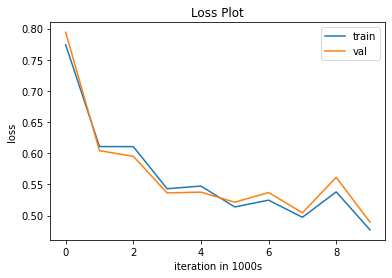

In [242]:
horiz_x_values = [i for i in range(len(train_loss_list))]
plt.plot(horiz_x_values, train_loss_list, label="train")
plt.plot(horiz_x_values, val_loss_list, label="val")
plt.title("Loss Plot")
plt.xlabel("iteration in 1000s")
plt.ylabel("loss")
plt.legend()

In [25]:
X_test, y_test = test_set
out = net(X_test)
preds = out > 0.5
test_acc = np.sum(np.squeeze(preds) == y_test)/X_test.shape[0]
print(f"test_acc = {test_acc:.4f}")

test_acc = 0.7485


I think that 74% accuracy on the test set is quite an impressive result for a fully connected network. From the loss plot we can see that although the loss has plateaued somewhat, the network has not really overfitted and the loss is still trending downwards slightly so it could benefit from further training.  
  
From previous experiments (which I was not able to reproduce and print in this notebook due to google colab taking away my GPU), I found that making the network deeper and deeper did not seem to improve performance too much. I think the main imrprovement from part 3 to part 5 is the Adam optimization algorithm.